# Import

In [9]:

import matplotlib.pyplot as plt
import sys
import os
import seaborn as sns
import mediapipe as mp
import torch

sys.path.append(os.path.abspath("../src"))

from utils.mpiifacegaze_dataset import *
from utils.mpiifacegaze_dataset import *
from tracker.GazeTrain import GazeTrain

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocessing - Stats

In [10]:
dataset = MPIIFaceGazeDataset(root_dir='../dataset/MPIIFaceGaze/')
df_mpi = dataset.to_dataframe(normalize=False)
df = dataset.to_dataframe(normalize=True)

In [4]:
print(df_mpi.head())

  subject                                    img_path  gaze_x  gaze_y
0     p00  ../dataset/MPIIFaceGaze/p00/day01/0005.jpg   476.0   758.0
1     p00  ../dataset/MPIIFaceGaze/p00/day01/0030.jpg  1078.0   693.0
2     p00  ../dataset/MPIIFaceGaze/p00/day01/0031.jpg   126.0   598.0
3     p00  ../dataset/MPIIFaceGaze/p00/day01/0038.jpg   211.0    69.0
4     p00  ../dataset/MPIIFaceGaze/p00/day01/0063.jpg   878.0   752.0


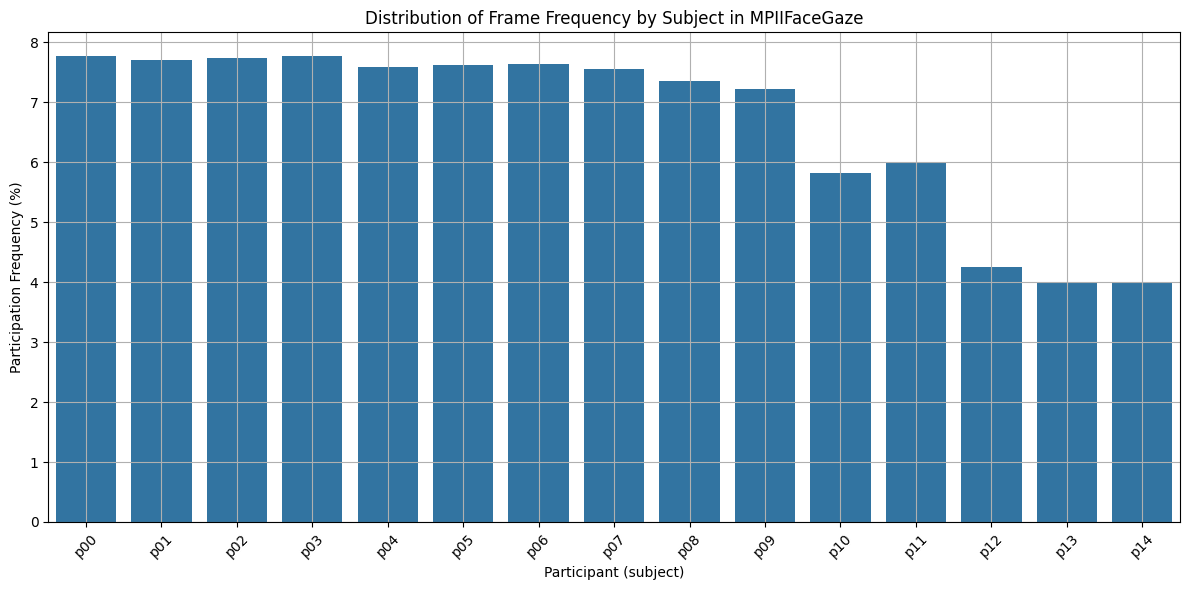

In [9]:
subject_counts = df_mpi['subject'].value_counts(normalize=True).sort_index() * 100

plt.figure(figsize=(12, 6))
sns.barplot(x=subject_counts.index, y=subject_counts.values)
plt.xticks(rotation=45)
plt.xlabel('Participant (subject)')
plt.ylabel('Participation Frequency (%)')
plt.title('Distribution of Frame Frequency by Subject in MPIIFaceGaze')
plt.tight_layout()
plt.grid(True)
plt.show()


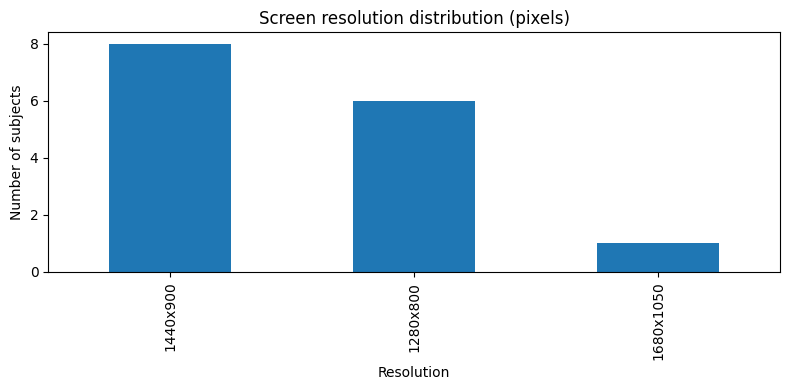

In [6]:
dataset.plot_screen_size_histogram()

In [ ]:
#generate_means(df)

I0000 00:00:1752070211.829002   48044 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1752070211.831459   48127 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) UHD Graphics 630 (CFL GT2)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
Computing mean tensors:   0%|          | 0/1178 [00:00<?, ?it/s]W0000 00:00:1752070211.836322   48114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752070211.858041   48113 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752070211.860968   48120 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
Computing mean tensors: 100%|█

Means saved successfully in:
  → ../src/mat/mean_face_224_MPIIFace.mat
  → ../src/mat/mean_left_224_MPIIFace.mat
  → ../src/mat/mean_right_224_MPIIFace.mat


In [11]:
df_skipped = pd.read_csv("skipped_images.csv",delimiter=" ")
df_clean = df[~df["img_path"].isin(df_skipped["img_path"])]

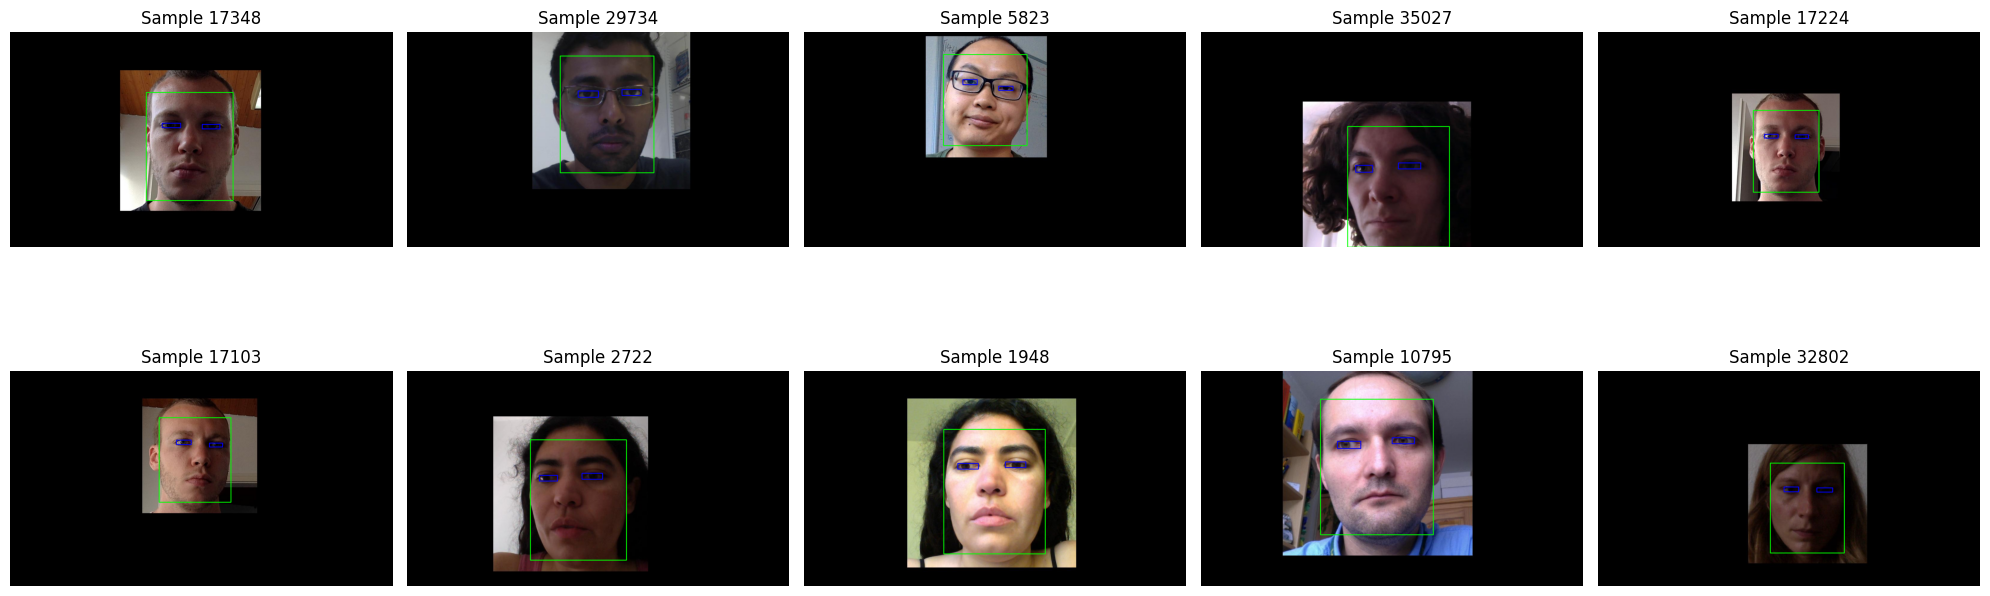

In [ ]:

face_mesh = mp.solutions.face_mesh.FaceMesh(
    static_image_mode=True,
    refine_landmarks=True,
    max_num_faces=1
)

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8)) 

for i in range(10):
    ax = axs[i // 5, i % 5]  
    idx = np.random.randint(len(df_clean))
    img_path = df_clean.iloc[idx]["img_path"]
    img = cv2.imread(img_path)

    if img is None:
        ax.axis("off")
        ax.set_title("Image not found")
        continue

    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_rgb)

    if results.multi_face_landmarks:
        landmarks = results.multi_face_landmarks[0]
        h, w, _ = img.shape
        points = [(int(pt.x * w), int(pt.y * h)) for pt in landmarks.landmark]

        left_eye_bbox = get_bounding_box(LEFT_EYE, points, w, h)
        right_eye_bbox = get_bounding_box(RIGHT_EYE, points, w, h)
        face_bbox = get_bounding_box(FACE_OVAL, points, w, h)

        img_drawn = draw_bounding_boxes(img.copy(), face_bbox, left_eye_bbox, right_eye_bbox)
        ax.imshow(cv2.cvtColor(img_drawn, cv2.COLOR_BGR2RGB))
        ax.set_title(f"Sample {idx}")
    else:
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title("No face detected")

    ax.axis("off")

plt.tight_layout()
plt.show()

In [12]:
len(df), len(df_clean)

(37667, 37600)

In [13]:
df_train, df_test = get_groupwise_train_test_split(df_clean, fold_index=0)

In [14]:
len(df_train), len(df_test)

(29690, 7910)

In [16]:
np.unique(df_train["subject"])

array(['p00', 'p01', 'p02', 'p04', 'p05', 'p06', 'p07', 'p08', 'p10',
       'p12', 'p13', 'p14'], dtype=object)

In [17]:
np.unique(df_test["subject"])

array(['p03', 'p09', 'p11'], dtype=object)

In [8]:
extract_and_save_batches(df_train,"train","../dataset/MPIIFaceGaze/batches")

I0000 00:00:1752656005.746609    6471 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1752656005.749070   14482 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) UHD Graphics 630 (CFL GT2)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1752656005.763964   14473 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.



=== Processing batch 1/30 (0 to 1000) ===


  0%|          | 0/1000 [00:00<?, ?it/s]W0000 00:00:1752656005.784220   14470 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752656005.798859   14471 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
100%|██████████| 1000/1000 [00:14<00:00, 71.11it/s]


[OK] Batch train 1 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_1.pkl

=== Processing batch 2/30 (1000 to 2000) ===


100%|██████████| 1000/1000 [00:15<00:00, 66.63it/s]


[OK] Batch train 2 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_2.pkl

=== Processing batch 3/30 (2000 to 3000) ===


100%|██████████| 1000/1000 [00:15<00:00, 64.30it/s]


[OK] Batch train 3 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_3.pkl

=== Processing batch 4/30 (3000 to 4000) ===


100%|██████████| 1000/1000 [00:15<00:00, 62.85it/s]


[OK] Batch train 4 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_4.pkl

=== Processing batch 5/30 (4000 to 5000) ===


100%|██████████| 1000/1000 [00:17<00:00, 58.46it/s]


[OK] Batch train 5 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_5.pkl

=== Processing batch 6/30 (5000 to 6000) ===


100%|██████████| 1000/1000 [00:16<00:00, 61.16it/s]


[OK] Batch train 6 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_6.pkl

=== Processing batch 7/30 (6000 to 7000) ===


100%|██████████| 1000/1000 [00:17<00:00, 55.94it/s]


[OK] Batch train 7 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_7.pkl

=== Processing batch 8/30 (7000 to 8000) ===


100%|██████████| 1000/1000 [00:18<00:00, 55.28it/s]


[OK] Batch train 8 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_8.pkl

=== Processing batch 9/30 (8000 to 9000) ===


100%|██████████| 1000/1000 [00:16<00:00, 60.19it/s]


[OK] Batch train 9 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_9.pkl

=== Processing batch 10/30 (9000 to 10000) ===


100%|██████████| 1000/1000 [00:16<00:00, 61.49it/s]


[OK] Batch train 10 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_10.pkl

=== Processing batch 11/30 (10000 to 11000) ===


100%|██████████| 1000/1000 [00:16<00:00, 59.73it/s]


[OK] Batch train 11 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_11.pkl

=== Processing batch 12/30 (11000 to 12000) ===


100%|██████████| 1000/1000 [00:16<00:00, 59.04it/s]


[OK] Batch train 12 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_12.pkl

=== Processing batch 13/30 (12000 to 13000) ===


100%|██████████| 1000/1000 [00:16<00:00, 59.01it/s]


[OK] Batch train 13 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_13.pkl

=== Processing batch 14/30 (13000 to 14000) ===


100%|██████████| 1000/1000 [00:17<00:00, 57.35it/s]


[OK] Batch train 14 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_14.pkl

=== Processing batch 15/30 (14000 to 15000) ===


100%|██████████| 1000/1000 [00:18<00:00, 55.36it/s]


[OK] Batch train 15 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_15.pkl

=== Processing batch 16/30 (15000 to 16000) ===


100%|██████████| 1000/1000 [00:16<00:00, 59.91it/s]


[OK] Batch train 16 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_16.pkl

=== Processing batch 17/30 (16000 to 17000) ===


100%|██████████| 1000/1000 [00:16<00:00, 59.64it/s]


[OK] Batch train 17 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_17.pkl

=== Processing batch 18/30 (17000 to 18000) ===


100%|██████████| 1000/1000 [00:17<00:00, 57.41it/s]


[OK] Batch train 18 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_18.pkl

=== Processing batch 19/30 (18000 to 19000) ===


100%|██████████| 1000/1000 [00:16<00:00, 59.04it/s]


[OK] Batch train 19 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_19.pkl

=== Processing batch 20/30 (19000 to 20000) ===


100%|██████████| 1000/1000 [00:18<00:00, 55.26it/s]


[OK] Batch train 20 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_20.pkl

=== Processing batch 21/30 (20000 to 21000) ===


100%|██████████| 1000/1000 [00:17<00:00, 56.33it/s]


[OK] Batch train 21 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_21.pkl

=== Processing batch 22/30 (21000 to 22000) ===


100%|██████████| 1000/1000 [00:17<00:00, 56.12it/s]


[OK] Batch train 22 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_22.pkl

=== Processing batch 23/30 (22000 to 23000) ===


100%|██████████| 1000/1000 [00:17<00:00, 57.56it/s]


[OK] Batch train 23 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_23.pkl

=== Processing batch 24/30 (23000 to 24000) ===


100%|██████████| 1000/1000 [00:17<00:00, 57.71it/s]


[OK] Batch train 24 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_24.pkl

=== Processing batch 25/30 (24000 to 25000) ===


100%|██████████| 1000/1000 [00:17<00:00, 56.93it/s]


[OK] Batch train 25 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_25.pkl

=== Processing batch 26/30 (25000 to 26000) ===


100%|██████████| 1000/1000 [00:17<00:00, 55.98it/s]


[OK] Batch train 26 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_26.pkl

=== Processing batch 27/30 (26000 to 27000) ===


100%|██████████| 1000/1000 [00:17<00:00, 58.71it/s]


[OK] Batch train 27 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_27.pkl

=== Processing batch 28/30 (27000 to 28000) ===


100%|██████████| 1000/1000 [00:17<00:00, 56.48it/s]


[OK] Batch train 28 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_28.pkl

=== Processing batch 29/30 (28000 to 29000) ===


100%|██████████| 1000/1000 [00:17<00:00, 56.97it/s]


[OK] Batch train 29 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_29.pkl

=== Processing batch 30/30 (29000 to 29690) ===


100%|██████████| 690/690 [00:11<00:00, 57.73it/s]


[OK] Batch train 30 saved to ../dataset/MPIIFaceGaze/batches/train/batch_train_30.pkl


In [9]:
extract_and_save_batches(df_test,"test","../dataset/MPIIFaceGaze/batches")

I0000 00:00:1752656597.627239    6471 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1752656597.652678   15192 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) UHD Graphics 630 (CFL GT2)
W0000 00:00:1752656597.663136   15178 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.



=== Processing batch 1/8 (0 to 1000) ===


100%|██████████| 1000/1000 [00:17<00:00, 56.75it/s]


[OK] Batch test 1 saved to ../dataset/MPIIFaceGaze/batches/test/batch_test_1.pkl

=== Processing batch 2/8 (1000 to 2000) ===


100%|██████████| 1000/1000 [00:17<00:00, 57.19it/s]


[OK] Batch test 2 saved to ../dataset/MPIIFaceGaze/batches/test/batch_test_2.pkl

=== Processing batch 3/8 (2000 to 3000) ===


100%|██████████| 1000/1000 [00:17<00:00, 56.65it/s]


[OK] Batch test 3 saved to ../dataset/MPIIFaceGaze/batches/test/batch_test_3.pkl

=== Processing batch 4/8 (3000 to 4000) ===


100%|██████████| 1000/1000 [00:17<00:00, 56.37it/s]


[OK] Batch test 4 saved to ../dataset/MPIIFaceGaze/batches/test/batch_test_4.pkl

=== Processing batch 5/8 (4000 to 5000) ===


100%|██████████| 1000/1000 [00:17<00:00, 57.36it/s]


[OK] Batch test 5 saved to ../dataset/MPIIFaceGaze/batches/test/batch_test_5.pkl

=== Processing batch 6/8 (5000 to 6000) ===


100%|██████████| 1000/1000 [00:17<00:00, 58.62it/s]


[OK] Batch test 6 saved to ../dataset/MPIIFaceGaze/batches/test/batch_test_6.pkl

=== Processing batch 7/8 (6000 to 7000) ===


100%|██████████| 1000/1000 [00:17<00:00, 56.73it/s]


[OK] Batch test 7 saved to ../dataset/MPIIFaceGaze/batches/test/batch_test_7.pkl

=== Processing batch 8/8 (7000 to 7910) ===


100%|██████████| 910/910 [00:15<00:00, 57.32it/s]


[OK] Batch test 8 saved to ../dataset/MPIIFaceGaze/batches/test/batch_test_8.pkl


# Training

In [3]:
model = GazeTrain(root_dir="../dataset/MPIIFaceGaze/batches/")


Epoch 1/15


Training on batches: 100%|██████████| 30/30 [30:16<00:00, 60.55s/it]


→ Train Loss: 0.014081


Validating on batches: 100%|██████████| 8/8 [01:33<00:00, 11.74s/it]


→ Val Loss: 0.021740

Epoch 2/15


Training on batches: 100%|██████████| 30/30 [30:03<00:00, 60.11s/it]


→ Train Loss: 0.007877


Validating on batches: 100%|██████████| 8/8 [01:27<00:00, 10.88s/it]


→ Val Loss: 0.017120

Epoch 3/15


Training on batches: 100%|██████████| 30/30 [28:30<00:00, 57.01s/it]


→ Train Loss: 0.006332


Validating on batches: 100%|██████████| 8/8 [01:25<00:00, 10.63s/it]


→ Val Loss: 0.015602

Epoch 4/15


Training on batches: 100%|██████████| 30/30 [32:37<00:00, 65.25s/it]


→ Train Loss: 0.005216


Validating on batches: 100%|██████████| 8/8 [01:36<00:00, 12.06s/it]


→ Val Loss: 0.015106

Epoch 5/15


Training on batches: 100%|██████████| 30/30 [32:58<00:00, 65.94s/it]


→ Train Loss: 0.004424


Validating on batches: 100%|██████████| 8/8 [01:38<00:00, 12.29s/it]


→ Val Loss: 0.015101

Epoch 6/15


Training on batches: 100%|██████████| 30/30 [32:58<00:00, 65.96s/it]


→ Train Loss: 0.003883


Validating on batches: 100%|██████████| 8/8 [01:46<00:00, 13.37s/it]


→ Val Loss: 0.014455

Epoch 7/15


Training on batches: 100%|██████████| 30/30 [34:01<00:00, 68.04s/it]


→ Train Loss: 0.003447


Validating on batches: 100%|██████████| 8/8 [01:45<00:00, 13.23s/it]


→ Val Loss: 0.015103

Epoch 8/15


Training on batches: 100%|██████████| 30/30 [31:42<00:00, 63.41s/it]


→ Train Loss: 0.003058


Validating on batches: 100%|██████████| 8/8 [01:27<00:00, 10.92s/it]


→ Val Loss: 0.015366

Epoch 9/15


Training on batches: 100%|██████████| 30/30 [28:45<00:00, 57.52s/it]


→ Train Loss: 0.002696


Validating on batches: 100%|██████████| 8/8 [01:26<00:00, 10.76s/it]


→ Val Loss: 0.015524

Epoch 10/15


Training on batches: 100%|██████████| 30/30 [29:33<00:00, 59.10s/it]


→ Train Loss: 0.002445


Validating on batches: 100%|██████████| 8/8 [01:30<00:00, 11.31s/it]


→ Val Loss: 0.014339

Epoch 11/15


Training on batches: 100%|██████████| 30/30 [29:10<00:00, 58.35s/it]


→ Train Loss: 0.002149


Validating on batches: 100%|██████████| 8/8 [01:28<00:00, 11.02s/it]


→ Val Loss: 0.015741

Epoch 12/15


Training on batches: 100%|██████████| 30/30 [29:12<00:00, 58.42s/it]


→ Train Loss: 0.001949


Validating on batches: 100%|██████████| 8/8 [01:27<00:00, 10.95s/it]


→ Val Loss: 0.014532

Epoch 13/15


Training on batches: 100%|██████████| 30/30 [29:06<00:00, 58.21s/it]


→ Train Loss: 0.001798


Validating on batches: 100%|██████████| 8/8 [01:28<00:00, 11.03s/it]


→ Val Loss: 0.014173

Epoch 14/15


Training on batches: 100%|██████████| 30/30 [29:05<00:00, 58.17s/it]


→ Train Loss: 0.001615


Validating on batches: 100%|██████████| 8/8 [01:28<00:00, 11.02s/it]


→ Val Loss: 0.013415

Epoch 15/15


Training on batches: 100%|██████████| 30/30 [29:09<00:00, 58.31s/it]


→ Train Loss: 0.001461


Validating on batches: 100%|██████████| 8/8 [01:26<00:00, 10.87s/it]

→ Val Loss: 0.014470


In [7]:
torch.save({'state_dict': model.state_dict()}, "../src/models/itracker_mpiiface.tar")